# Introduction

This project analyzes data from the [Stack Overflow Developer Survey 2025](https://survey.stackoverflow.co/), the fifteenth annual report on the state of software development.  
The survey collected over 49,000 responses, covering 62 questions. 
The survey is structured into five sections:
- Learning and Career  
- Tech and Tech Culture  
- Community  
- AI  
- Final Thoughts  

The focus of this project is to evaluate **AI adoption** in relation to personal and career background. Accordingly, I will restrict the analysis to features from the **Learning and Career** section, which include variables on education, skills, professional experience, job role, and work environment. I exclude the *Tech and Tech Culture*, *Community*, *AI follow-up*, and *Final Thoughts* sections, as they are either outside the scope of this study or may directly leak information about the target variable.

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay, confusion_matrix,classification_report

In [65]:
import requests, zipfile, io

In [66]:
#This code downloads a ZIP file from GitHub, opens it directly from memory, finds the first CSV inside, and loads it into a Pandas DataFrame

url = "https://github.com/alejandraberbesi/DataScience_BlogPost/blob/main/survey_results_public.zip?raw=true"
response = requests.get(url)
response.raise_for_status()

with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    csv_file = [f for f in z.namelist() if f.endswith(".csv")][0]
    with z.open(csv_file) as f:
        df = pd.read_csv(f)

In [67]:
# Load dataset
df.head(5)

,ResponseId,MainBranch,Age,EdLevel,Employment,EmploymentAddl,WorkExp,LearnCodeChoose,LearnCode,LearnCodeAI,...,AIAgentOrchestration,AIAgentOrchWrite,AIAgentObserveSecure,AIAgentObsWrite,AIAgentExternal,AIAgentExtWrite,AIHuman,AIOpen,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,25-34 years old,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Employed,"Caring for dependents (children, elderly, etc.)",8.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",...,Vertex AI,NaN,NaN,NaN,ChatGPT,NaN,When I don’t trust AI’s answers,"Troubleshooting, profiling, debugging",61256.0,10.0
1,2,I am a developer by profession,25-34 years old,"Associate degree (A.A., A.S., etc.)",Employed,NaN,2.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,NaN,NaN,When I don’t trust AI’s answers;When I want to...,All skills. AI is a flop.,104413.0,9.0
2,3,I am a developer by profession,35-44 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Independent contractor, freelancer, or self-em...",None of the above,10.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,ChatGPT;Claude Code;GitHub Copilot;Google Gemini,NaN,When I don’t trust AI’s answers;When I want to...,"Understand how things actually work, problem s...",53061.0,8.0
3,4,I am a developer by profession,35-44 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed,None of the above,4.0,"Yes, I am not new to coding but am learning ne...","Other online resources (e.g. standard search, ...","Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,ChatGPT;Claude Code,NaN,When I don’t trust AI’s answers;When I want to...,NaN,36197.0,6.0
4,5,I am a developer by profession,35-44 years old,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Independent contractor, freelancer, or self-em...","Caring for dependents (children, elderly, etc.)",21.0,"No, I am not new to coding and did not learn n...",NaN,"Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,NaN,NaN,When I don’t trust AI’s answers,"critical thinking, the skill to define the tas...",60000.0,7.0


In [68]:
# Check shape before cleaning
print("Initial shape:", df.shape)

# Check duplicates
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)

# Drop duplicates if any
if duplicates > 0:
    df = d.drop_duplicates()
    print("Duplicates dropped.")

# Check shape after cleaning
print("Final shape:", df.shape)

Initial shape: (49123, 170)
Number of duplicate rows: 0
Final shape: (49123, 170)


## Target Definition

The main goal of this analysis is to study **AI adoption** among developers.  
To simplify both the analysis and the machine learning process, the target variable is reduced to a binary **Yes/No** classification.  

**Original survey question:**  
*"Do you currently use AI tools in your development process?"*

**Original answers:**
- Yes, I use AI tools daily  
- Yes, I use AI tools weekly  
- Yes, I use AI tools monthly or infrequently  
- No, but I plan to soon  
- No, and I don’t plan to  

**Transformed target:**
- **Yes** → daily / weekly / monthly or infrequently  
- **No** → plan to soon / don’t plan to  

This transformation converts the problem into a straightforward binary classification task: **predicting AI adoption (Yes vs. No)**.

In [69]:
df['AISelect'].unique()

array(['Yes, I use AI tools monthly or infrequently',
       'Yes, I use AI tools weekly', 'Yes, I use AI tools daily',
       "No, and I don't plan to", nan, 'No, but I plan to soon'],
      dtype=object)

In [70]:
# Define target
yes_responses = [
    "Yes, I use AI tools daily",
    "Yes, I use AI tools weekly",
    "Yes, I use AI tools monthly or infrequently"
]
no_responses = [
    "No, but I plan to soon",
    "No, and I don't plan to"
]

df["AIUse_Binary"] = df["AISelect"].map(
    lambda x: "Yes" if x in yes_responses 
    else ("No" if x in no_responses else np.nan)
)

# Drop rows with missing target
df = df.dropna(subset=["AIUse_Binary"])

print("Target distribution:")
print(df["AIUse_Binary"].value_counts(normalize=True))

Target distribution:
AIUse_Binary
Yes    0.784836
No     0.215164
Name: proportion, dtype: float64


In [71]:
# Find position of AISelect (target)
ai_index = df.columns.get_loc("AIUse_Binary")

# Keep only Learning & Career section + target
learning_career_cols = df.columns[1:62].tolist()
selected_cols = learning_career_cols + ["AIUse_Binary"]
filtered_df = df[selected_cols].copy()

# Drop open-text columns inside this subset
exclude_text_cols = [col for col in filtered_df.columns 
                     if "_TEXT" in col or "Entry" in col or col.endswith("Write")]
final_df = filtered_df.drop(columns=exclude_text_cols, errors="ignore")

print("Original columns:", df.shape[1])
print("Columns after filtering:", final_df.shape[1])

Original columns: 171
Columns after filtering: 59


In [72]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33686 entries, 0 to 49121
Data columns (total 59 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MainBranch         33686 non-null  object 
 1   Age                33686 non-null  object 
 2   EdLevel            33614 non-null  object 
 3   Employment         33686 non-null  object 
 4   EmploymentAddl     31795 non-null  object 
 5   WorkExp            31090 non-null  float64
 6   LearnCodeChoose    33654 non-null  object 
 7   LearnCode          24566 non-null  object 
 8   LearnCodeAI        33616 non-null  object 
 9   AILearnHow         21541 non-null  object 
 10  YearsCode          33240 non-null  float64
 11  DevType            33686 non-null  object 
 12  OrgSize            26751 non-null  object 
 13  ICorPM             26195 non-null  object 
 14  RemoteWork         26540 non-null  object 
 15  PurchaseInfluence  29525 non-null  object 
 16  TechEndorseIntro   32723 no

# Exploratory Data Analysis (EDA)

In [73]:
# Compute counts
mainbranch_counts = df['MainBranch'].value_counts()

# Compute percentages
mainbranch_percent = df['MainBranch'].value_counts(normalize=True) * 100

# Combine into a DataFrame
mainbranch_summary = pd.DataFrame({
    'Count': mainbranch_counts,
    'Percentage': mainbranch_percent
})

mainbranch_summary

,Count,Percentage
MainBranch,,
I am a developer by profession,26018,77.236834
"I am not primarily a developer, but I write code sometimes as part of my work/studies",3498,10.384136
I am learning to code,1358,4.031348
I code primarily as a hobby,1302,3.865107
"I used to be a developer by profession, but no longer am",923,2.740011
I work with developers or my work supports developers but am not a developer by profession,587,1.742564


**Most respondents (77%) identify as professional developers, while smaller groups code for work/studies (10%) or are learning/hobbyists.**

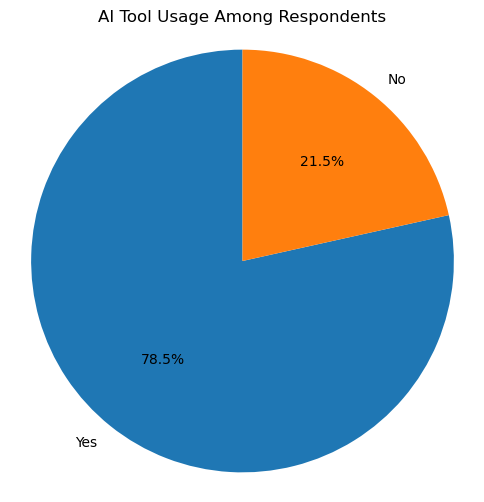

In [74]:
# Compute counts
ai_counts = df['AIUse_Binary'].value_counts()

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(ai_counts, labels=ai_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('AI Tool Usage Among Respondents')
plt.axis('equal') 
plt.show()

**A large majority (78.5%) of respondents report using AI tools, while 21.5% do not.**

In [75]:
def plot_ai_percentage(df, cat_col,ai_filter, target_col='AIUse_Binary',figsize=(10,6)):
    """
    Plot the distribution of a categorical variable for selected AI usage ('Yes', 'No') as percentages,
    with bars sorted from highest to lowest.
    
    Parameters:
    - df: pandas DataFrame
    - cat_col: str, the categorical column to plot
    - ai_filter: str, 'Yes', 'No'
    - target_col: str, the target column (default 'AIUse_Binary')
    - figsize: tuple, size of the plot
    """
    df = df[df[target_col] == ai_filter]
    
    # Compute percentages
    value_counts = df[cat_col].value_counts(normalize=True) * 100
    value_counts = value_counts.sort_values(ascending=False)  # sort descending
    
    # Plot
    plt.figure(figsize=figsize)
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.ylabel('Percentage (%)')
    plt.xlabel(cat_col)
    plt.title(f'Distribution of {cat_col} for AI usage: {ai_filter}')
    
    # Add percentage labels
    for i, v in enumerate(value_counts.values):
        plt.text(i, v + 1, f"{v:.1f}%", ha='center')
    
    plt.xticks(rotation=90, ha='right')
    plt.ylim(0, 110)
    plt.show()

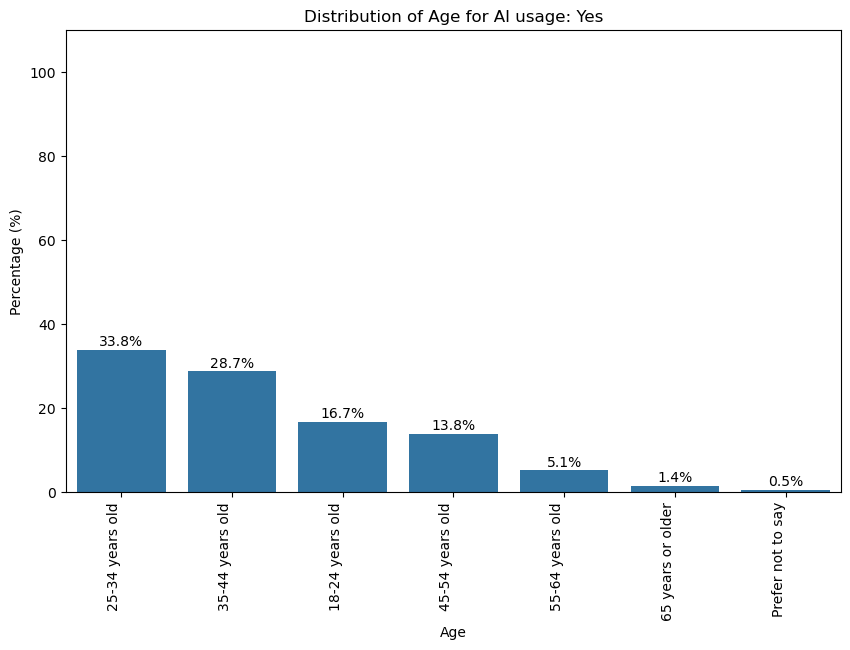

In [76]:
plot_ai_percentage(df, 'Age', ai_filter='Yes')

**AI usage is highest among 25–34 (33.8%) and 35–44 (28.7%) year-olds, with lower adoption in older age groups.**  


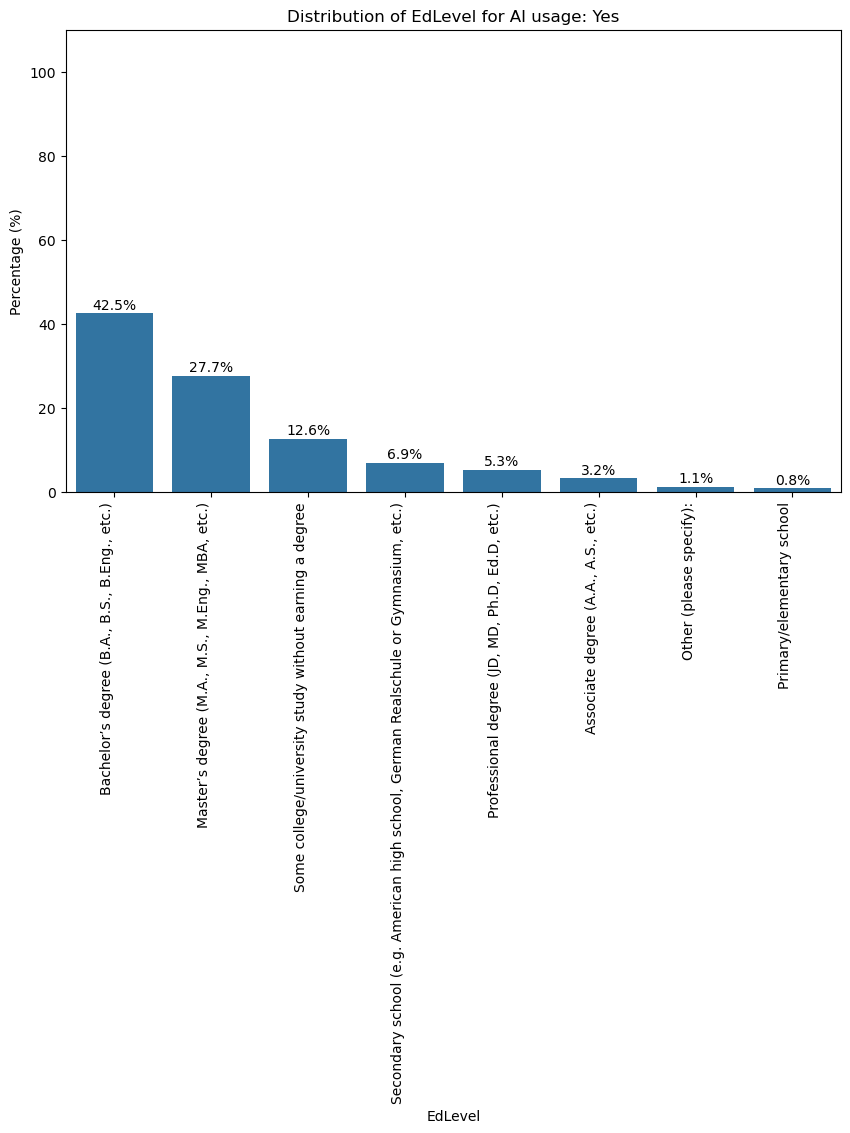

In [77]:
plot_ai_percentage(df, 'EdLevel', ai_filter='Yes')

**Most AI users hold a Bachelor’s (42.5%) or Master’s degree (27.7%), with smaller shares across other education levels.**  


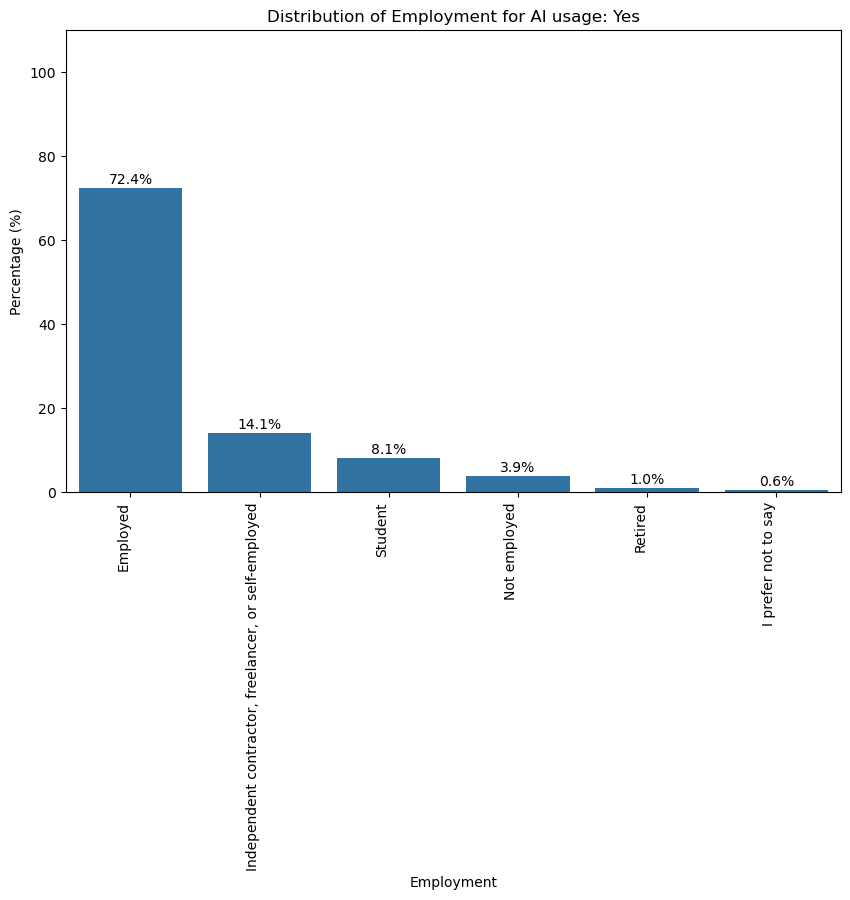

In [78]:
plot_ai_percentage(df, 'Employment', ai_filter='Yes')

**The majority of AI users are employed (72.4%), followed by freelancers/self-employed (14.1%) and students (8.1%).**  


In [79]:
def plot_numeric_ai_users(df, num_col, ai_filter, target_col='AIUse_Binary', figsize=(10,6), bins=20):
    """
    Plot a numeric variable as a histogram for selected AI usage ('Yes', 'No'),
    and show counts above each bar.
    
    Parameters:
    - df: pandas DataFrame
    - num_col: str, numeric column to plot
    - ai_filter: str, 'Yes', 'No'
    - target_col: str, AI usage column (default 'AIUse_Binary')
    - figsize: tuple, figure size
    - bins: int, number of bins for the histogram
    """

    df_plot = df[df[target_col] == ai_filter]
    
    values = df_plot[num_col].dropna()
    
    # Compute histogram counts and bins
    counts, bin_edges = np.histogram(values, bins=bins)
    
    plt.figure(figsize=figsize)
    
    # Plot histogram
    sns.histplot(values, bins=bins, kde=False, color='skyblue', edgecolor='black')
    
    # Add counts above each bar
    for i in range(len(counts)):
        plt.text(
            x=(bin_edges[i] + bin_edges[i+1])/2,  # middle of the bin
            y=counts[i] + 0.5,                   # slightly above the bar
            s=str(counts[i]),
            ha='center',
            va='bottom'
        )
    
    plt.xlabel(num_col)
    plt.ylabel('Count')
    plt.title(f'{num_col} distribution for AI users ({ai_filter})')
    plt.tight_layout()
    plt.show()

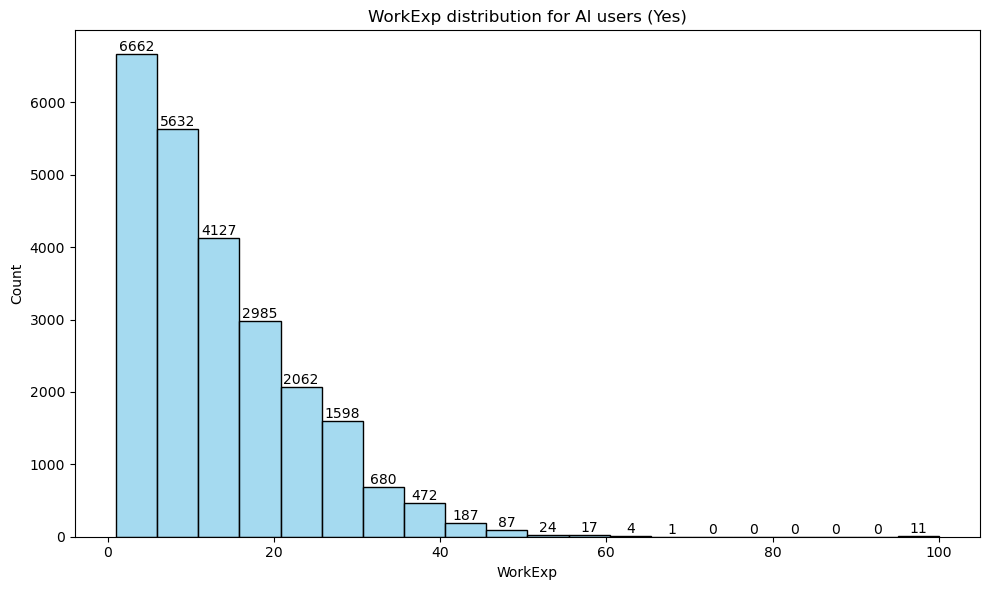

In [80]:
plot_numeric_ai_users(df, 'WorkExp', ai_filter='Yes')

In [81]:
values = df[df['AIUse_Binary'] == 'Yes']['WorkExp'].dropna()

# Compute histogram counts and bins
counts, bin_edges = np.histogram(values, bins=20)

# Compute percentages
percentages = counts / counts.sum() * 100

hist_table = pd.DataFrame({
    'Bin Start': bin_edges[:-1].round(1),
    'Bin End': bin_edges[1:].round(1),
    'Count': counts,
    'Percentage': percentages.round(2)
})

hist_table

,Bin Start,Bin End,Count,Percentage
0,1.0,6.0,6662,27.14
1,6.0,10.9,5632,22.94
2,10.9,15.8,4127,16.81
3,15.8,20.8,2985,12.16
4,20.8,25.8,2062,8.40
5,25.8,30.7,1598,6.51
6,30.7,35.6,680,2.77
7,35.6,40.6,472,1.92
8,40.6,45.6,187,0.76
9,45.6,50.5,87,0.35


**Most AI users have under 10 years of work experience, with usage declining sharply among those with more experience.**  

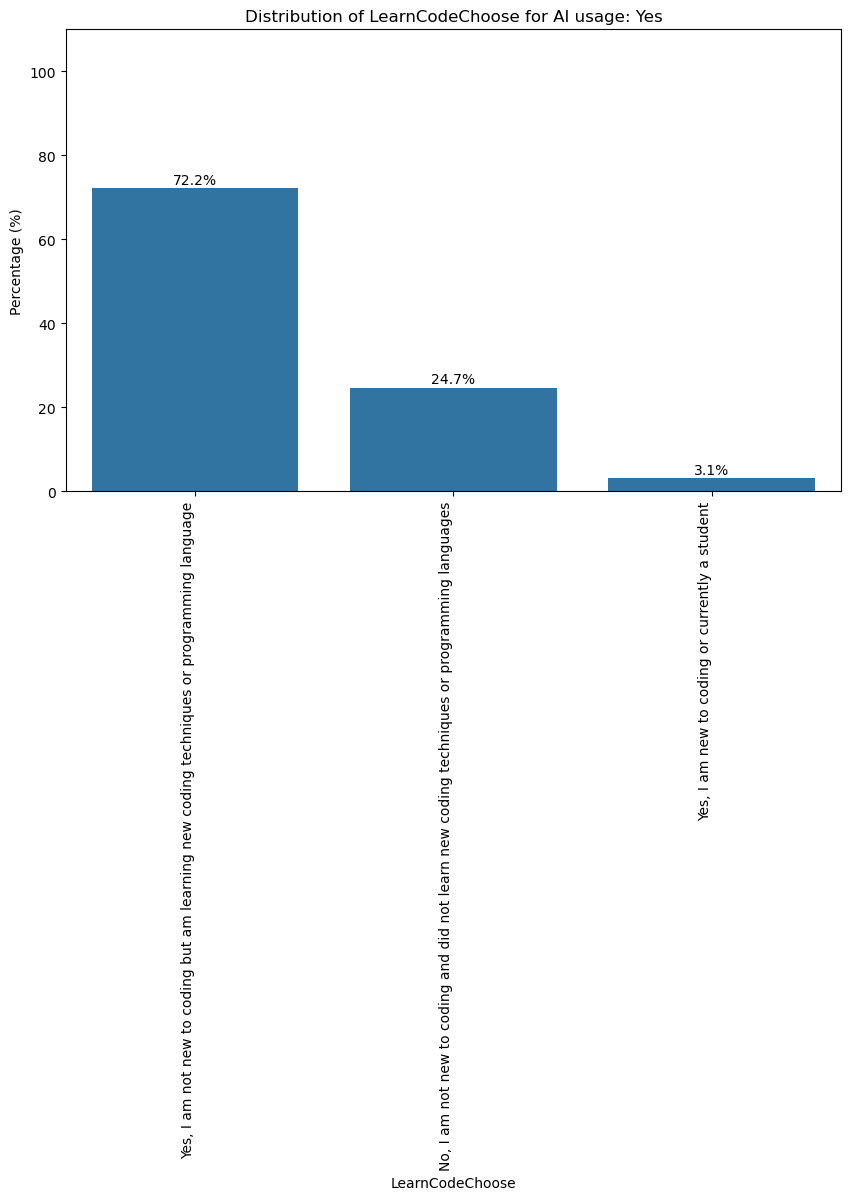

In [82]:
plot_ai_percentage(df, 'LearnCodeChoose', ai_filter='Yes')

**Most AI users (72.2%) are improving existing coding skills, while 24.7% are new to coding and 3.1% are students.**  


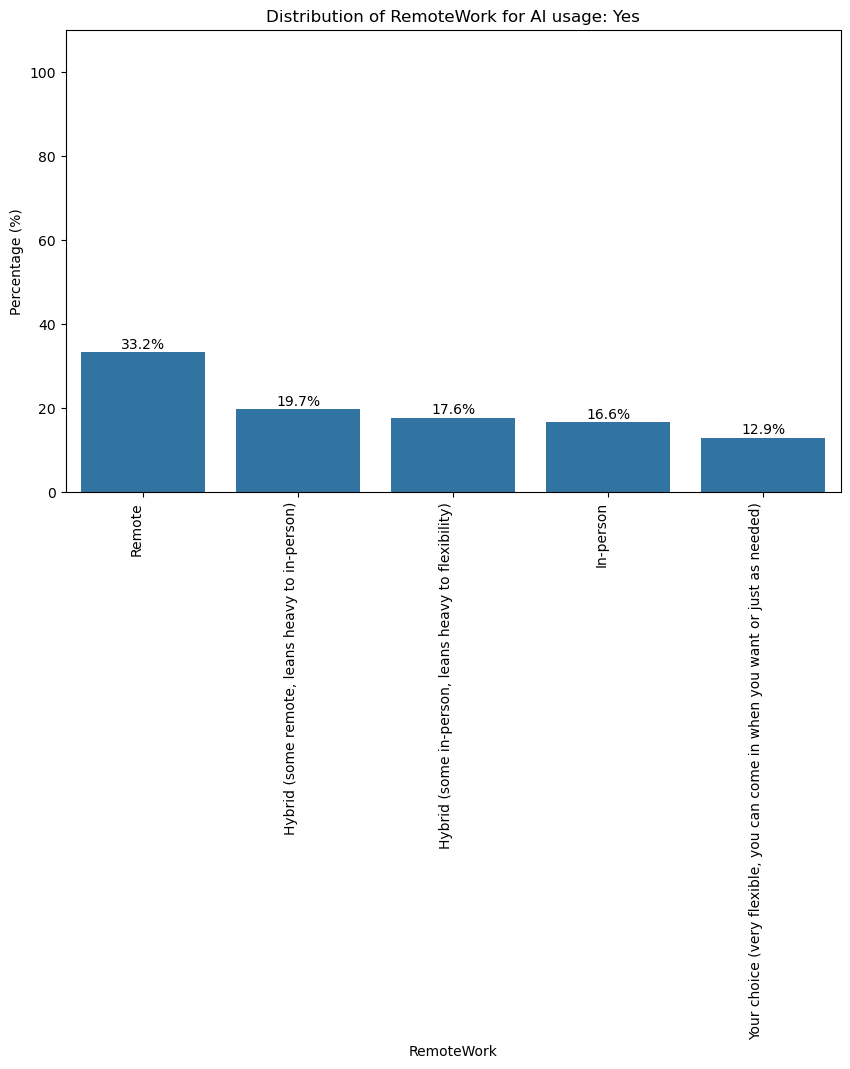

In [83]:
plot_ai_percentage(df, 'RemoteWork', ai_filter='Yes')

**One-third of AI users (33.2%) work fully remote, while the rest are split across hybrid, in-person, and flexible setups.**  


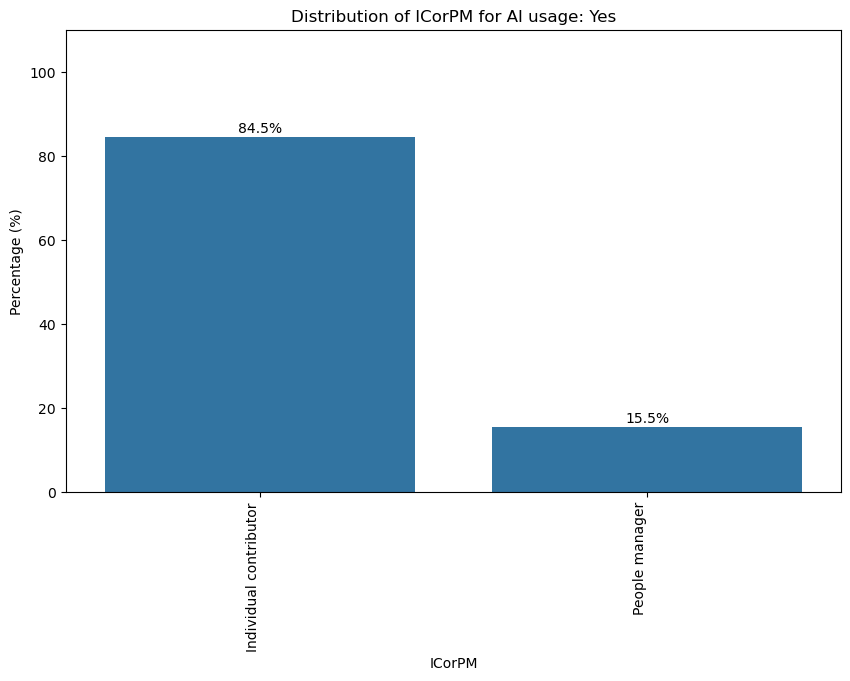

In [84]:
plot_ai_percentage(df, 'ICorPM', ai_filter='Yes')

**Most AI users (84.5%) are individual contributors, while only 15.5% are people managers.**  

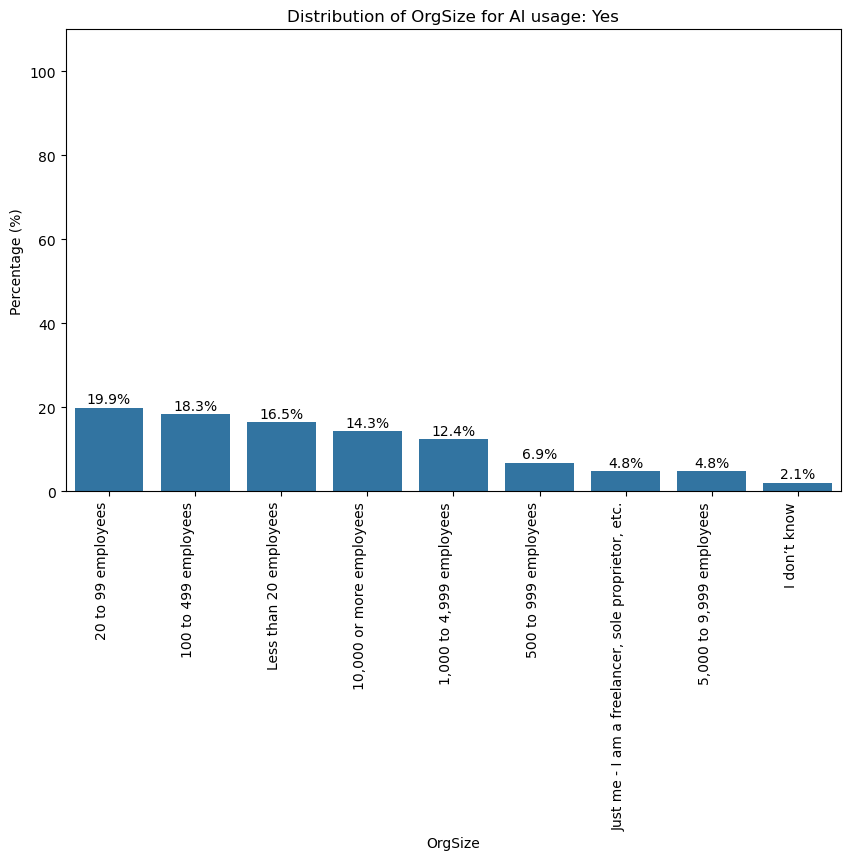

In [85]:
plot_ai_percentage(df, 'OrgSize', ai_filter='Yes')

**AI users are spread across all org sizes, with the largest shares in mid-sized companies (20–499 employees, ~38%).**  


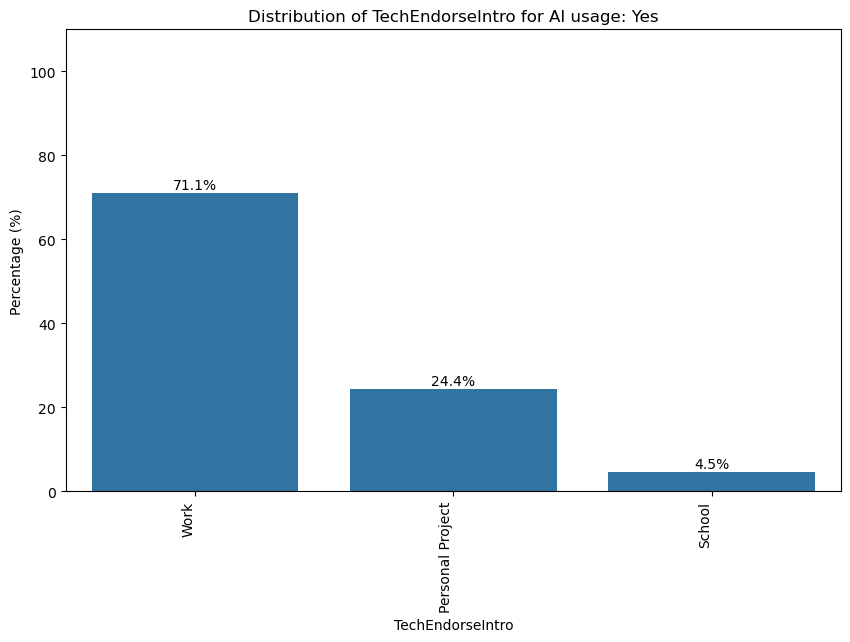

In [86]:
plot_ai_percentage(df, 'TechEndorseIntro', ai_filter='Yes')

**A majority of survey respondents (71.1%) report using AI for work projects.**

# Summary of Findings

**Business Questions**

- What is the current rate of AI adoption among survey respondents?
- What are the demographic characteristics of AI adopters, in terms of age and education level?
- What is the employment status and level of experience among AI adopters?
- How prevalent is continuous learning and professional development among AI adopters?
- What are the characteristics of the workforce among AI adopters, in terms of remote work and job roles?

**Key Findings**

- 78.5% of survey respondents currently use AI in their development process, indicating a high level of AI adoption.
- The majority of AI adopters are between 25 and 34 years old (33.8%), with a significant drop-off among those 55 and older (6.5%). Additionally, - 42.5% have a Bachelor's degree and 27.7% have a Master's degree, highlighting the educational background of AI adopters.
- 72.4% of AI adopters are employed, with around 50% having less than 10 years of working experience, indicating a relatively young and employed workforce.
- 72.2% of AI adopters have learned new programming languages or coding techniques in the last year, demonstrating a strong commitment to continuous learning and professional development.
- The workforce among AI adopters is characterized by 33.2% remote workers and 84.5% individual contributors, highlighting the prevalence of remote work and individual contributor roles.

## Data cleaning and data preprocessing

In [87]:
# Check shape before cleaning
print("Initial shape:", final_df.shape)

# Check duplicates
duplicates = final_df.duplicated().sum()
print("Number of duplicate rows:", duplicates)

# Drop duplicates if any
if duplicates > 0:
    final_df = final_df.drop_duplicates()
    print("Duplicates dropped.")

# Check shape after cleaning
print("Final shape:", final_df.shape)

Initial shape: (33686, 59)
Number of duplicate rows: 0
Final shape: (33686, 59)


In [88]:
# DataFrame for missing values
null_df = (
    final_df.isnull().sum()
    .reset_index()
    .rename(columns={"index": "Column", 0: "MissingValues"})
)

# Add percentage of missing values
null_df["MissingPercent"] = (null_df["MissingValues"] / len(final_df)) * 100

# Sort by MissingPercent (descending)
null_df = null_df.sort_values(by="MissingPercent", ascending=False).reset_index(drop=True)

null_df

,Column,MissingValues,MissingPercent
0,AILearnHow,12145,36.053553
1,JobSatPoints_9,10123,30.051060
2,JobSatPoints_4,10123,30.051060
3,JobSatPoints_5,10123,30.051060
4,JobSatPoints_6,10123,30.051060
5,JobSatPoints_7,10123,30.051060
6,JobSatPoints_8,10123,30.051060
7,JobSatPoints_10,10123,30.051060
8,JobSatPoints_1,10123,30.051060
9,JobSatPoints_11,10123,30.051060


**Handling Missing Values in general**:

I noticed that upon reviewing the survey data, some values in columns such as `LearnCodeChoose`, `EdLevel`, `YearsCode`, `TechEndorseIntro`, `WorkExp`, `OrgSize`, `RemoteWork`, `ICorPM`,`PurchaseInfluence`, `NewRole` and `LearnCode` were recorded as null, despite "null" not being a valid response option in the survey, indicating errors in the data processing pipeline. Given the significant amount of data available and the fact that many machine learning algorithms I plan to use do not tolerate missing values, I have decided to drop the rows that contain missing values to ensure that my analysis is based on a clean dataset.

In [89]:
columns_to_check = ['LearnCodeChoose', 'EdLevel', 'YearsCode', 'TechEndorseIntro', 'WorkExp', 'OrgSize', 'RemoteWork', 'ICorPM','PurchaseInfluence','NewRole','LearnCode']

final_df = final_df.dropna(subset=columns_to_check)

**Avoiding Data Leakage**

I must exclude features that could leak information about the target variable.In this dataset, two Learning and Career questions are directly related to AI usage:  

- LearnCodeAI: Did you spend time in the last year learning AI programming or AI-enabled tooling?  
- AILearnHow: How are you learning AI programming or AI-enabled tooling?
- AIThreat: Do you believe AI is a threat to your current job?

Both variables describe prior AI learning behavior and are strongly correlated with the target `AISelect`.  
Including them would artificially boost model accuracy. Therefore, they are excluded from the feature set.

In [90]:
final_df = final_df.drop(columns=["LearnCodeAI","AILearnHow","AIThreat"])

**Excluding EmploymentAddl and TechEndorseIntro to Avoid Duplication**

- `EmploymentAddl` is supplementary to primary employment status, so it will be removed.  
- `TechEndorseIntro` duplicates information for the ranking of TechEndorse, so it will also be dropped.

In [91]:
final_df = final_df.drop(['EmploymentAddl','TechEndorseIntro'], axis=1)

**Excluding TechOppose Questions:**
I excluded TechOppose questions to avoid feature redundancy, as they are highly related to TechEndorse questions and may not add significant new information.

In [92]:
tech_oppose_cols = [col for col in final_df.columns if col.startswith('TechOppose')]
final_df = final_df.drop(tech_oppose_cols, axis=1)

**Excluding Job Attribute Ranking**: I excluded the columns related to ranking job attributes, as they provide detailed information that is not essential given the presence of a current job satisfaction measure. This exclusion simplifies the feature space and focuses the analysis on more relevant variables.

In [93]:
job_sat_cols = [col for col in final_df.columns if col.startswith('JobSatPoints')]
final_df = final_df.drop(job_sat_cols, axis=1)

**Excluding Contextual Variables**:To focus on identifying universal factors driving AI adoption, I excluded **contextual or time-bound variables** that are less generalizable across populations. These include **Industry, Country, Currency, Compensation, LearnCode, and LearnCodeChoose** (which capture region-specific, financial, or short-term learning behaviors, such as whether respondents began learning to code in the past year).

In [94]:
final_df = final_df.drop(columns=["Country","Currency","CompTotal","Industry", "LearnCode", "LearnCodeChoose"])

**Tool Usage Metrics**: The columns "ToolCountWork" and "ToolCountPersonal" both relate to the number of platforms or software applications used by individuals, with the distinction being that one pertains to work-related tools and the other to personal ones. By averaging these two values, I create a new metric "tool_count_avg" that captures the overall tool usage. I then impute missing values in tool_count_avg with the median because it's robust to outliers.

In [95]:
final_df['tool_count_avg'] = final_df[['ToolCountWork', 'ToolCountPersonal']].mean(axis=1)
final_df = final_df.drop(columns=['ToolCountWork', 'ToolCountPersonal'])
final_df['tool_count_avg'] = final_df['tool_count_avg'].fillna(final_df['tool_count_avg'].median())
final_df.isnull().sum()

MainBranch             0
Age                    0
EdLevel                0
Employment             0
WorkExp                0
YearsCode              0
DevType                0
OrgSize                0
ICorPM                 0
RemoteWork             0
PurchaseInfluence      0
TechEndorse_1        534
TechEndorse_2        534
TechEndorse_3        534
TechEndorse_4        534
TechEndorse_5        534
TechEndorse_6        534
TechEndorse_7        534
TechEndorse_8        534
TechEndorse_9        534
TechEndorse_13       534
NewRole                0
AIUse_Binary           0
tool_count_avg         0
dtype: int64

**Handling Missing Responses for Tech Endorsement Questions**: Upon reviewing the dataset, I noticed that several respondents did not answer the tech endorsement questions. To maintain data quality, I removed the rows corresponding to these non-responses, as they were missing all values.

In [96]:
tech_endorse_cols = [f'TechEndorse_{i}' for i in range(1, 10)] + ['TechEndorse_13']
subset_df = final_df[tech_endorse_cols][final_df[tech_endorse_cols].isnull().any(axis=1)]
print(subset_df.isnull().all(axis=1).all())

True


In [97]:
final_df = final_df.dropna(subset=tech_endorse_cols, how='all')
final_df.isnull().sum()

MainBranch           0
Age                  0
EdLevel              0
Employment           0
WorkExp              0
YearsCode            0
DevType              0
OrgSize              0
ICorPM               0
RemoteWork           0
PurchaseInfluence    0
TechEndorse_1        0
TechEndorse_2        0
TechEndorse_3        0
TechEndorse_4        0
TechEndorse_5        0
TechEndorse_6        0
TechEndorse_7        0
TechEndorse_8        0
TechEndorse_9        0
TechEndorse_13       0
NewRole              0
AIUse_Binary         0
tool_count_avg       0
dtype: int64

**The "Tech Endorse" question asks respondents to rank 10 possible options. I'm only keeping the 1st answer because it represents the most important factor, providing a clear insight into the primary driver of technology endorsement. This simplification helps to focus on the most critical aspect, making it easier to analyze and model the data.**

In [98]:
tech_endorse_cols2=[f'TechEndorse_{i}' for i in range(2, 10)] + ['TechEndorse_13']
final_df = final_df.drop(columns=tech_endorse_cols2)
final_df.columns

Index(['MainBranch', 'Age', 'EdLevel', 'Employment', 'WorkExp', 'YearsCode',
       'DevType', 'OrgSize', 'ICorPM', 'RemoteWork', 'PurchaseInfluence',
       'TechEndorse_1', 'NewRole', 'AIUse_Binary', 'tool_count_avg'],
      dtype='object')

### Feature Encoding

In [99]:
def group_and_dummy_encode(df, column, mapping):

    """
    Map a categorical column to grouped categories and apply one-hot encoding.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame.
    column : str
        Column to transform.
    mapping : dict
        Maps original values to grouped categories.

    Returns
    -------
    pandas.DataFrame
        DataFrame with the column replaced by dummy-encoded features.
    """
    
    df[f'{column}_Grouped'] = df[column].map(mapping)
    dummies = pd.get_dummies(df[f'{column}_Grouped'], prefix=column)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(columns=[column, f'{column}_Grouped'])
    return df

In [100]:
main_branch_mapping = {
    'I am a developer by profession': 'Developer',
    'I used to be a developer by profession, but no longer am': 'Developer',
    'I am not primarily a developer, but I write code sometimes as part of my work/studies': 'Non_Developer',
    'I work with developers or my work supports developers but am not a developer by profession': 'Non_Developer',
    'I code primarily as a hobby': 'Learner',
    'I am learning to code': 'Learner'
}

final_df = group_and_dummy_encode(final_df, 'MainBranch', main_branch_mapping)

In [101]:
age_mapping = {
    '18-24 years old': 'Young',
    '25-34 years old': 'Mid',
    '35-44 years old': 'Mid',
    '45-54 years old': 'Senior',
    '55-64 years old': 'Senior',
    '65 years or older': 'Senior',
    'Prefer not to say': 'Other'  
}
final_df = group_and_dummy_encode(final_df, 'Age', age_mapping)

In [102]:
edlevel_mapping = {
    "Master’s degree (M.A., M.S., M.Eng., MBA, etc.)": "Graduate",
    "Professional degree (JD, MD, Ph.D, Ed.D, etc.)": "Graduate",
    "Bachelor’s degree (B.A., B.S., B.Eng., etc.)": "Graduate",
    "Associate degree (A.A., A.S., etc.)": "Associate/Some_College",
    "Some college/university study without earning a degree": "Associate/Some_College",
    "Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)": "School",
    "Primary/elementary school": "School",
    "Other (please specify):": "Other"
}
final_df = group_and_dummy_encode(final_df, "EdLevel", edlevel_mapping)

In [103]:
role_mapping = {
    # Developer Roles
    "Developer, mobile": "Developer",
    "Developer, back-end": "Developer",
    "Developer, full-stack": "Developer",
    "Developer, embedded applications or devices": "Developer",
    "Developer, front-end": "Developer",
    "Developer, game or graphics": "Developer",
    "Developer, AI apps or physical AI": "Developer",
    "Developer, desktop or enterprise applications": "Developer",
    "Developer, QA or test": "Developer",
    "Architect, software or solutions": "Developer",

    # Data & AI Roles
    "Data engineer": "Data/AI",
    "Data or business analyst": "Data/AI",
    "Data scientist": "Data/AI",
    "Database administrator or engineer": "Data/AI",
    "Applied scientist": "Data/AI",
    "AI/ML engineer": "Data/AI",

    # Management / Leadership
    "Engineering manager": "Management",
    "Project manager": "Management",
    "Product manager": "Management",
    "Senior executive (C-suite, VP, etc.)": "Management",
    "Founder, technology or otherwise": "Management",

    # Other Tech Roles
    "DevOps engineer or professional": "Other_Tech",
    "Cloud infrastructure engineer": "Other_Tech",
    "System administrator": "Other_Tech",
    "Cybersecurity or InfoSec professional": "Other_Tech",
    "Support engineer or analyst": "Other_Tech",
    "Financial analyst or engineer": "Other_Tech",
    "UX, Research Ops or UI design professional": "Other_Tech",

    # Non-Tech / Misc
    "Academic researcher": "Non-Tech/Misc",
    "Student": "Non-Tech/Misc",
    "Retired": "Non-Tech/Misc",
    "Other (please specify):": "Non-Tech/Misc"
}

final_df = group_and_dummy_encode(final_df, "DevType", role_mapping)

In [104]:
orgsize_mapping = {
    "Just me - I am a freelancer, sole proprietor, etc.": "Small",
    "Less than 20 employees": "Small",
    "20 to 99 employees": "Small",

    "100 to 499 employees": "Medium",
    "500 to 999 employees": "Medium",
    "1,000 to 4,999 employees": "Medium",

    "5,000 to 9,999 employees": "Large",
    "10,000 or more employees": "Large",
    "I don’t know": "Unknown"  
}
final_df = group_and_dummy_encode(final_df, "OrgSize", orgsize_mapping)

In [105]:
remotework_mapping = {
    "Remote": "Remote",
    "Hybrid (some in-person, leans heavy to flexibility)": "Hybrid",
    "Hybrid (some remote, leans heavy to in-person)": "Hybrid",
    "Your choice (very flexible, you can come in when you want or just as needed)": "Hybrid",
    "In-person": "In-person"
}

final_df = group_and_dummy_encode(final_df, "RemoteWork", remotework_mapping)

In [106]:
purchase_influence_mapping = {
    "Yes, I influenced the purchase of a substantial addition to the tech stack": "Influenced",
    "Yes, I influenced the purchase of a tool that more than five colleagues use but it is not a substantial addition to the tech stack": "Influenced",
    "Yes, I endorsed a tool that was open-source and is currently used by more than just myself but no purchase was made": "Influenced",
    "Yes, I endorsed a tool that was ultimately not purchased or used at my organization": "Influenced",
    "No": "Not_Influenced"
}
final_df = group_and_dummy_encode(final_df, "PurchaseInfluence", purchase_influence_mapping)

In [107]:
newrole_mapping = {
    "I have neither consider or transitioned into a new career or industry": "No_Change",
    "I have strongly considered changing my career and/or the industry I work in": "Considered_Change",
    "I have somewhat considered changing my career and/or the industry I work in": "Considered_Change",
    "I have transitioned into a new career and/or industry voluntarily": "Transitioned",
    "I have transitioned into a new career and/or industry involuntarily": "Transitioned"
}

final_df = group_and_dummy_encode(final_df, "NewRole", newrole_mapping)

In [108]:
TechEndorse_mapping = {
    1.0: 'AI_Integration',
    2.0: 'Easy_API',
    3.0: 'Robust_API',
    4.0: 'Customizable_Codebase',
    5.0: 'Quality_Reputation',
    6.0: 'Open-source',
    7.0: 'Brand_Image',
    8.0: 'Reliability',
    9.0: 'Manageable_Costs',
    10.0: 'Other'
}
final_df = group_and_dummy_encode(final_df, 'TechEndorse_1', TechEndorse_mapping)


In [109]:
final_df = pd.get_dummies(final_df, columns=["Employment","ICorPM"], prefix=["Employment","ICorPM"])

In [110]:
final_df.head(3)

,WorkExp,YearsCode,AIUse_Binary,tool_count_avg,MainBranch_Developer,MainBranch_Learner,MainBranch_Non_Developer,Age_Mid,Age_Other,Age_Senior,...,TechEndorse_1_Other,TechEndorse_1_Quality_Reputation,TechEndorse_1_Reliability,TechEndorse_1_Robust_API,Employment_Employed,"Employment_Independent contractor, freelancer, or self-employed",Employment_Not employed,Employment_Student,ICorPM_Individual contributor,ICorPM_People manager
0,8.0,14.0,Yes,5.0,True,False,False,True,False,False,...,True,False,False,False,True,False,False,False,False,True
1,2.0,10.0,Yes,5.5,True,False,False,True,False,False,...,False,False,False,False,True,False,False,False,True,False
3,4.0,5.0,Yes,6.0,True,False,False,True,False,False,...,False,False,False,False,True,False,False,False,True,False


In [111]:
final_df["AIUse_Binary"] = final_df["AIUse_Binary"].map({"Yes": 1, "No": 0}).astype("int")

In [112]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17067 entries, 0 to 49106
Data columns (total 48 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   WorkExp                                                          17067 non-null  float64
 1   YearsCode                                                        17067 non-null  float64
 2   AIUse_Binary                                                     17067 non-null  int32  
 3   tool_count_avg                                                   17067 non-null  float64
 4   MainBranch_Developer                                             17067 non-null  bool   
 5   MainBranch_Learner                                               17067 non-null  bool   
 6   MainBranch_Non_Developer                                         17067 non-null  bool   
 7   Age_Mid                                      

# Modeling

In [113]:
final_df.head(3)

,WorkExp,YearsCode,AIUse_Binary,tool_count_avg,MainBranch_Developer,MainBranch_Learner,MainBranch_Non_Developer,Age_Mid,Age_Other,Age_Senior,...,TechEndorse_1_Other,TechEndorse_1_Quality_Reputation,TechEndorse_1_Reliability,TechEndorse_1_Robust_API,Employment_Employed,"Employment_Independent contractor, freelancer, or self-employed",Employment_Not employed,Employment_Student,ICorPM_Individual contributor,ICorPM_People manager
0,8.0,14.0,1,5.0,True,False,False,True,False,False,...,True,False,False,False,True,False,False,False,False,True
1,2.0,10.0,1,5.5,True,False,False,True,False,False,...,False,False,False,False,True,False,False,False,True,False
3,4.0,5.0,1,6.0,True,False,False,True,False,False,...,False,False,False,False,True,False,False,False,True,False


In [114]:
# ⚠️ Class imbalance: the target variable is heavily skewed, which can bias models towards the majority class.
print("Class Proportions:")
print(final_df['AIUse_Binary'].value_counts(normalize=True))

Class Proportions:
AIUse_Binary
1    0.823519
0    0.176481
Name: proportion, dtype: float64


In [115]:
# Features and target
X = final_df.drop(columns=["AIUse_Binary"])
y =final_df["AIUse_Binary"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13653, 47), (3414, 47), (13653,), (3414,))

## Model Training with Hyperparameter Tuning

I will train and optimize two models:
- **Random Forest**: A strong and interpretable baseline, robust with many dummy features, captures non-linear patterns, and gives useful feature importance.  
- **XGBoost**: More advanced boosting method, usually higher accuracy, handles sparse dummy data efficiently, includes regularization, and scales well.  

To tune hyperparameters, I will use **RandomizedSearchCV** with cross-validation. This balances performance and efficiency compared to Grid Search.

In [116]:
# Random Forest search space
rf_param_grid = {
    "n_estimators": [100, 200, 500], # Number of trees in the forest
    "max_depth": [None, 5, 10, 20], # Maximum depth of each tree
    "min_samples_split": [2, 5, 10],# Minimum number of samples required to split a node
    "bootstrap": [True, False] #(True = bootstrap, False = use the whole dataset)
}

rf = RandomForestClassifier(random_state=255,class_weight="balanced")

rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid,
    n_iter=20,
    cv=5,
    verbose=1,
    random_state=422,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=255),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 5, 10, 20],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500]},
                   random_state=422, verbose=1)

In [117]:
# XGBoost search space
xgb_param_grid = {
    "n_estimators": [100, 200, 500], # Number of boosting rounds (trees)
    "max_depth": [3, 5, 10], # Maximum depth of each tree
    "learning_rate": [0.01, 0.05, 0.1, 0.2], # Step size shrinkage used in each boosting step
    "subsample": [0.6, 0.8, 1.0], #Ratio of the training data randomly sampled for growing each tree
    }

# Calculate class imbalance ratio
num_neg = np.sum(y_train == 0)
num_pos = np.sum(y_train == 1)
scale_pos_weight = num_neg / num_pos

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=853,
    scale_pos_weight=scale_pos_weight
)

xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_grid,
    n_iter=20,
    cv=5,
    verbose=1,
    random_state=244,
    n_jobs=-1
)

xgb_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 10],
                                        'n_estimators': [100, 200, 500],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=244, verbose=1)

### Model Evaluation

I will compare both models on the test set using:
- F1 Score (balance of precision and recall)
- ROC-AUC Score (ability to separate classes across thresholds)

In [118]:
# Best models
best_rf = rf_search.best_estimator_
best_xgb = xgb_search.best_estimator_

# Predictions
rf_preds = best_rf.predict(X_test)
xgb_preds = best_xgb.predict(X_test)

rf_probs = best_rf.predict_proba(X_test)[:, 1]
xgb_probs = best_xgb.predict_proba(X_test)[:, 1]

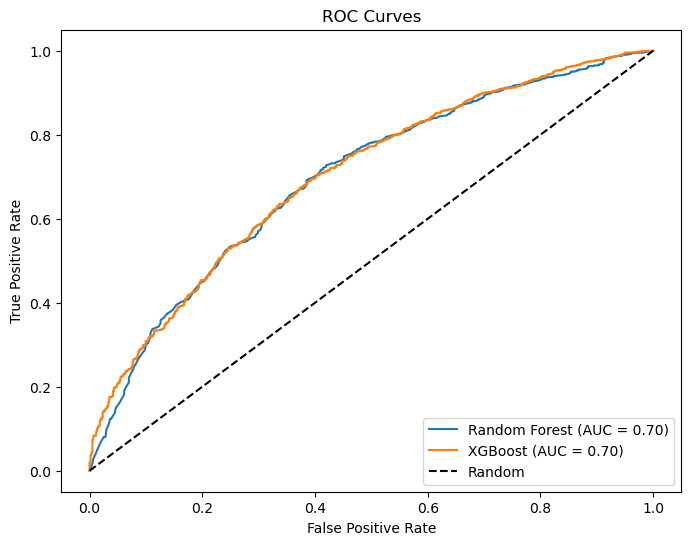

In [119]:
# --- ROC Curves ---
plt.figure(figsize=(8, 6))

# RF ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")

# XGB ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.2f})")

# Random line
plt.plot([0, 1], [0, 1], "k--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.show()

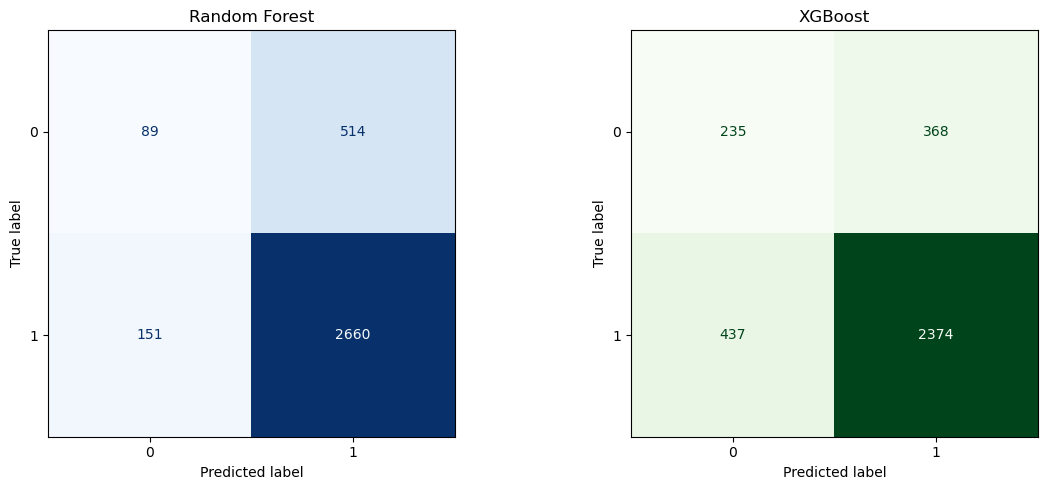

In [120]:
# --- Confusion Matrices ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Random Forest confusion matrix
cm_rf = confusion_matrix(y_test, rf_preds)
ConfusionMatrixDisplay(cm_rf).plot(ax=axes[0], cmap="Blues", colorbar=False)
axes[0].set_title("Random Forest")

# XGBoost confusion matrix
cm_xgb = confusion_matrix(y_test, xgb_preds)
ConfusionMatrixDisplay(cm_xgb).plot(ax=axes[1], cmap="Greens", colorbar=False)
axes[1].set_title("XGBoost")

plt.tight_layout()
plt.show()

In [121]:
# --- Classification Reports ---
print("=== Random Forest Classification Report ===")
print(classification_report(y_test, rf_preds))

print("\n=== XGBoost Classification Report ===")
print(classification_report(y_test, xgb_preds))

=== Random Forest Classification Report ===
              precision    recall  f1-score   support

           0       0.37      0.15      0.21       603
           1       0.84      0.95      0.89      2811

    accuracy                           0.81      3414
   macro avg       0.60      0.55      0.55      3414
weighted avg       0.76      0.81      0.77      3414


=== XGBoost Classification Report ===
              precision    recall  f1-score   support

           0       0.35      0.39      0.37       603
           1       0.87      0.84      0.86      2811

    accuracy                           0.76      3414
   macro avg       0.61      0.62      0.61      3414
weighted avg       0.77      0.76      0.77      3414



### Model Comparison Results

The Random Forest model produced an overall accuracy of 81%, which looks strong at first glance. Its performance on the majority class (Class 1) was excellent, with a recall of 0.95 and an F1 score of 0.89. This means the model correctly identified almost all instances of the majority class. However, the model performed poorly on the minority class (Class 0), with recall dropping to only 0.15 and an F1 score of 0.21. **In practical terms, Random Forest failed to detect most of the minority cases, which significantly limits its usefulness when detecting Class 0 is important for the problem being studied.** Accuracy in this case is misleading, as the model is mainly "playing it safe" by almost always predicting the majority class.  

XGBoost, by contrast, delivered a slightly lower overall accuracy of 76%. However, its performance on the minority class was much more balanced. It achieved a recall of 0.39 and an F1 score of 0.37 for Class 0, which represents a considerable improvement over Random Forest. While its recall for the majority class was somewhat lower than Random Forest (0.84 vs 0.95), XGBoost still provided reliable predictions for the majority group with an F1 score of 0.86. This demonstrates that XGBoost sacrifices a small portion of majority class performance in order to substantially improve the detection of minority class cases.  

**Therefore, XGBoost is the more appropriate model in this context, especially if we value fair performance across both classes rather than accuracy driven mostly by the majority class.**

# Prediction Scenario

**Let’s imagine a practical case:**

- A 33-year-old data scientist (Developer/Data/AI role) with ~8 years of coding experience.
- Holds a graduate degree (Master’s) and is currently employed full-time.
- Works for a large organization with a hybrid schedule.
- Has influenced tech purchase decisions before.
- Recently considered a career change but stayed in AI.
- Endorses AI for integration and manageable costs.
- Is an individual contributor (not people manager).

**Code to Make Prediction**:

In [122]:
# Example respondent with your feature columns
new_data = pd.DataFrame([{
    "WorkExp": 10,   # years of work experience
    "YearsCode": 8,  # years coding

    "AIUse_Binary": 1,
    "tool_count_avg": 5,

    # Main branch
    "MainBranch_Developer": 0,
    "MainBranch_Learner": 0,
    "MainBranch_Non_Developer": 0,

    # Age
    "Age_Mid": 1,
    "Age_Other": 0,
    "Age_Senior": 0,
    "Age_Young": 0,

    # Education
    "EdLevel_Associate/Some_College": 0,
    "EdLevel_Graduate": 1,
    "EdLevel_Other": 0,
    "EdLevel_School": 0,

    # Dev Type
    "DevType_Data/AI": 1,
    "DevType_Developer": 0,
    "DevType_Management": 0,
    "DevType_Non-Tech/Misc": 0,
    "DevType_Other_Tech": 0,

    # Org Size
    "OrgSize_Large": 1,
    "OrgSize_Medium": 0,
    "OrgSize_Small": 0,
    "OrgSize_Unknown": 0,

    # Remote Work
    "RemoteWork_Hybrid": 1,
    "RemoteWork_In-person": 0,
    "RemoteWork_Remote": 0,

    # Purchase Influence
    "PurchaseInfluence_Influenced": 1,
    "PurchaseInfluence_Not_Influenced": 0,

    # New Role
    "NewRole_Considered_Change": 1,
    "NewRole_No_Change": 0,
    "NewRole_Transitioned": 0,

    # Tech Endorsements
    "TechEndorse_1_AI_Integration": 1,
    "TechEndorse_1_Brand_Image": 0,
    "TechEndorse_1_Customizable_Codebase": 0,
    "TechEndorse_1_Easy_API": 0,
    "TechEndorse_1_Manageable_Costs": 1,
    "TechEndorse_1_Open-source": 0,
    "TechEndorse_1_Other": 0,
    "TechEndorse_1_Quality_Reputation": 0,
    "TechEndorse_1_Reliability": 0,
    "TechEndorse_1_Robust_API": 0,

    # Employment
    "Employment_Employed": 1,
    "Employment_Independent contractor, freelancer, or self-employed": 0,
    "Employment_Not employed": 0,
    "Employment_Student": 0,

    # Role
    "ICorPM_Individual contributor": 1,
    "ICorPM_People manager": 0
}])

# Align with training columns
new_data = new_data.reindex(columns=X_train.columns, fill_value=0)

# Predict with the best model (you can try best_rf or best_xgb)
prediction = best_xgb.predict(new_data)[0]
probability = best_xgb.predict_proba(new_data)[0][1]

print(f"Predicted AI Adoption: {'Yes' if prediction==1 else 'No'}")
print(f"Probability of Adoption: {probability:.2f}")

Predicted AI Adoption: Yes
Probability of Adoption: 0.89


**Interpretation and Usefulness**

This prediction suggests that an employee with these characteristics — a mid-career data/AI professional with advanced education, employed at a large organization, endorsing AI integration, and influencing purchase decisions — has an 89% likelihood of adopting AI tools.

Such insights are valuable because they:

- Guide organizations: Companies can see which employee profiles are highly likely to adopt AI and focus training or incentives on groups with lower predicted likelihood.
- Inform policy/education: Policymakers and educators can identify subgroups (e.g., students, small company workers, non-technical roles) that may lag in adoption, and design interventions or training programs for them.
- Assist individuals: Professionals can see how career development, education, and active engagement with technology influence adoption probability, encouraging continuous skill development.